# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [30]:
import xarray as xr
import folium
import polars as pl
import gc

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import polars as pl

%matplotlib inline

In [31]:
# ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc')

In [32]:
# ds

In [33]:
polars_df = pl.read_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.parquet")

In [34]:
polars_df.head()

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,PRECIPITATIONCAL,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-4.5,39.375,20.554688,300.632812,301.40625,100119.3125,4.09375,5.2890625,0.016479,72.6875,0.4453125,0.4765625,0.40625,0.0,43.009766,263.890625
2001-01-01 00:00:00,-4.0,29.375,73.023438,296.335938,296.882812,88100.625,1.109375,1.5,0.01416,70.4375,0.8359375,0.8359375,0.8515625,3.369934,94.381348,190.95752
2001-01-01 00:00:00,-4.0,30.0,51.226562,293.84375,293.578125,85654.125,0.15625,0.8203125,0.013672,78.4375,0.7578125,0.765625,0.7890625,14.408289,93.867188,197.355469
2001-01-01 00:00:00,-4.0,38.75,8.21875,298.867188,300.398438,95377.0,3.2109375,4.5234375,0.01416,68.8125,0.515625,0.546875,0.453125,0.0,44.986328,242.912109
2001-01-01 00:00:00,-4.0,39.375,4.1875,300.398438,301.90625,98870.0,3.3515625,4.703125,0.015198,69.0625,0.4609375,0.4921875,0.4140625,0.0,45.098633,244.987305


## Data Inspection

### Area of intrest - East Africa

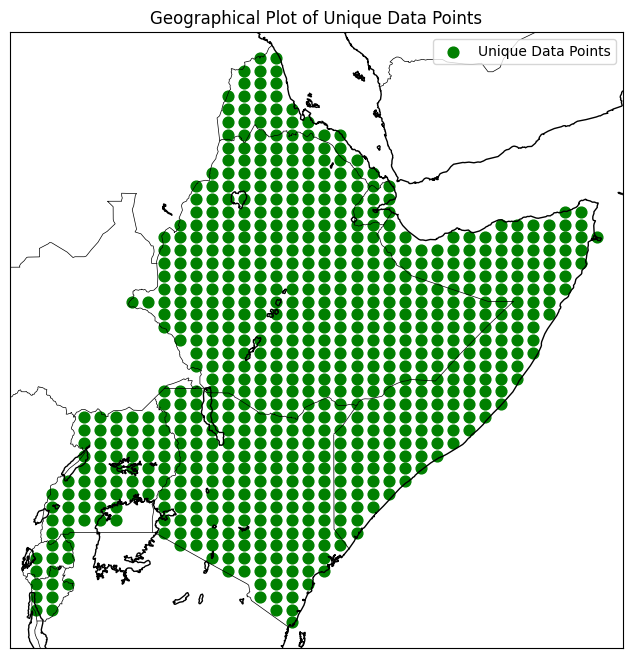

In [35]:
def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()

# Example usage:
plot_geographical_data(polars_df)


### Missing values

In [36]:
def calculate_missing_percentages(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.

    Example of usage:
    missing_percentages = calculate_missing_percentages(polars_df)
    print(missing_percentages)
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    missing_counts = df.select([pl.col(column).is_null().sum().alias(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

# Example usage
missing_percentages = calculate_missing_percentages(polars_df)


In [37]:
missing_percentages

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,PRECIPITATIONCAL,CLOUD_AMT,ALLSKY_SFC_SW_DWN
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Descriptive statistics

### Summmary statistics

In [38]:
summary_stats_polars = polars_df.describe()
summary_stats_polars

statistic,time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,PRECIPITATIONCAL,CLOUD_AMT,ALLSKY_SFC_SW_DWN
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""5874536""",5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6,5.874536e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-09 12:…",5.899862,39.899862,11.855052,297.949032,299.45884,90968.39804,2.966884,4.113798,0.012012,59.15737,0.491661,0.498911,0.407992,1.955022,48.640978,247.105817
"""std""",null,4.837268,4.689481,20.858518,4.305426,4.889064,6539.57661,1.658559,2.052343,0.002823,15.452239,0.144552,0.146319,0.21215,5.824804,27.410578,42.053827
"""min""","""2001-01-01 00:…",-4.5,29.375,0.0,279.023438,277.945312,72258.625,0.0078125,0.3125,0.00116,6.3125,0.203125,0.203125,0.0546875,-41.78842,0.0,26.056641
"""25%""","""2006-07-22 00:…",2.0,36.875,0.0,295.007812,296.109375,86384.0625,1.6796875,2.515625,0.010376,48.375,0.375,0.3828125,0.2265625,0.0,24.984375,222.490234
"""50%""","""2012-02-10 00:…",6.0,39.375,0.7578125,298.53125,300.0,91826.375,2.640625,3.6875,0.012207,59.4375,0.4609375,0.46875,0.375,0.0,47.280273,253.40625
"""75%""","""2017-08-30 00:…",9.5,43.125,14.414062,301.023438,302.953125,96265.0,3.96875,5.3671875,0.013977,70.6875,0.578125,0.5859375,0.5546875,0.681267,71.728027,278.130859
"""max""","""2023-03-20 00:…",17.5,51.25,167.804688,313.898438,319.820312,101828.75,12.796875,16.78125,0.022827,97.75,1.0,1.0,1.0,378.216334,99.992188,349.711914


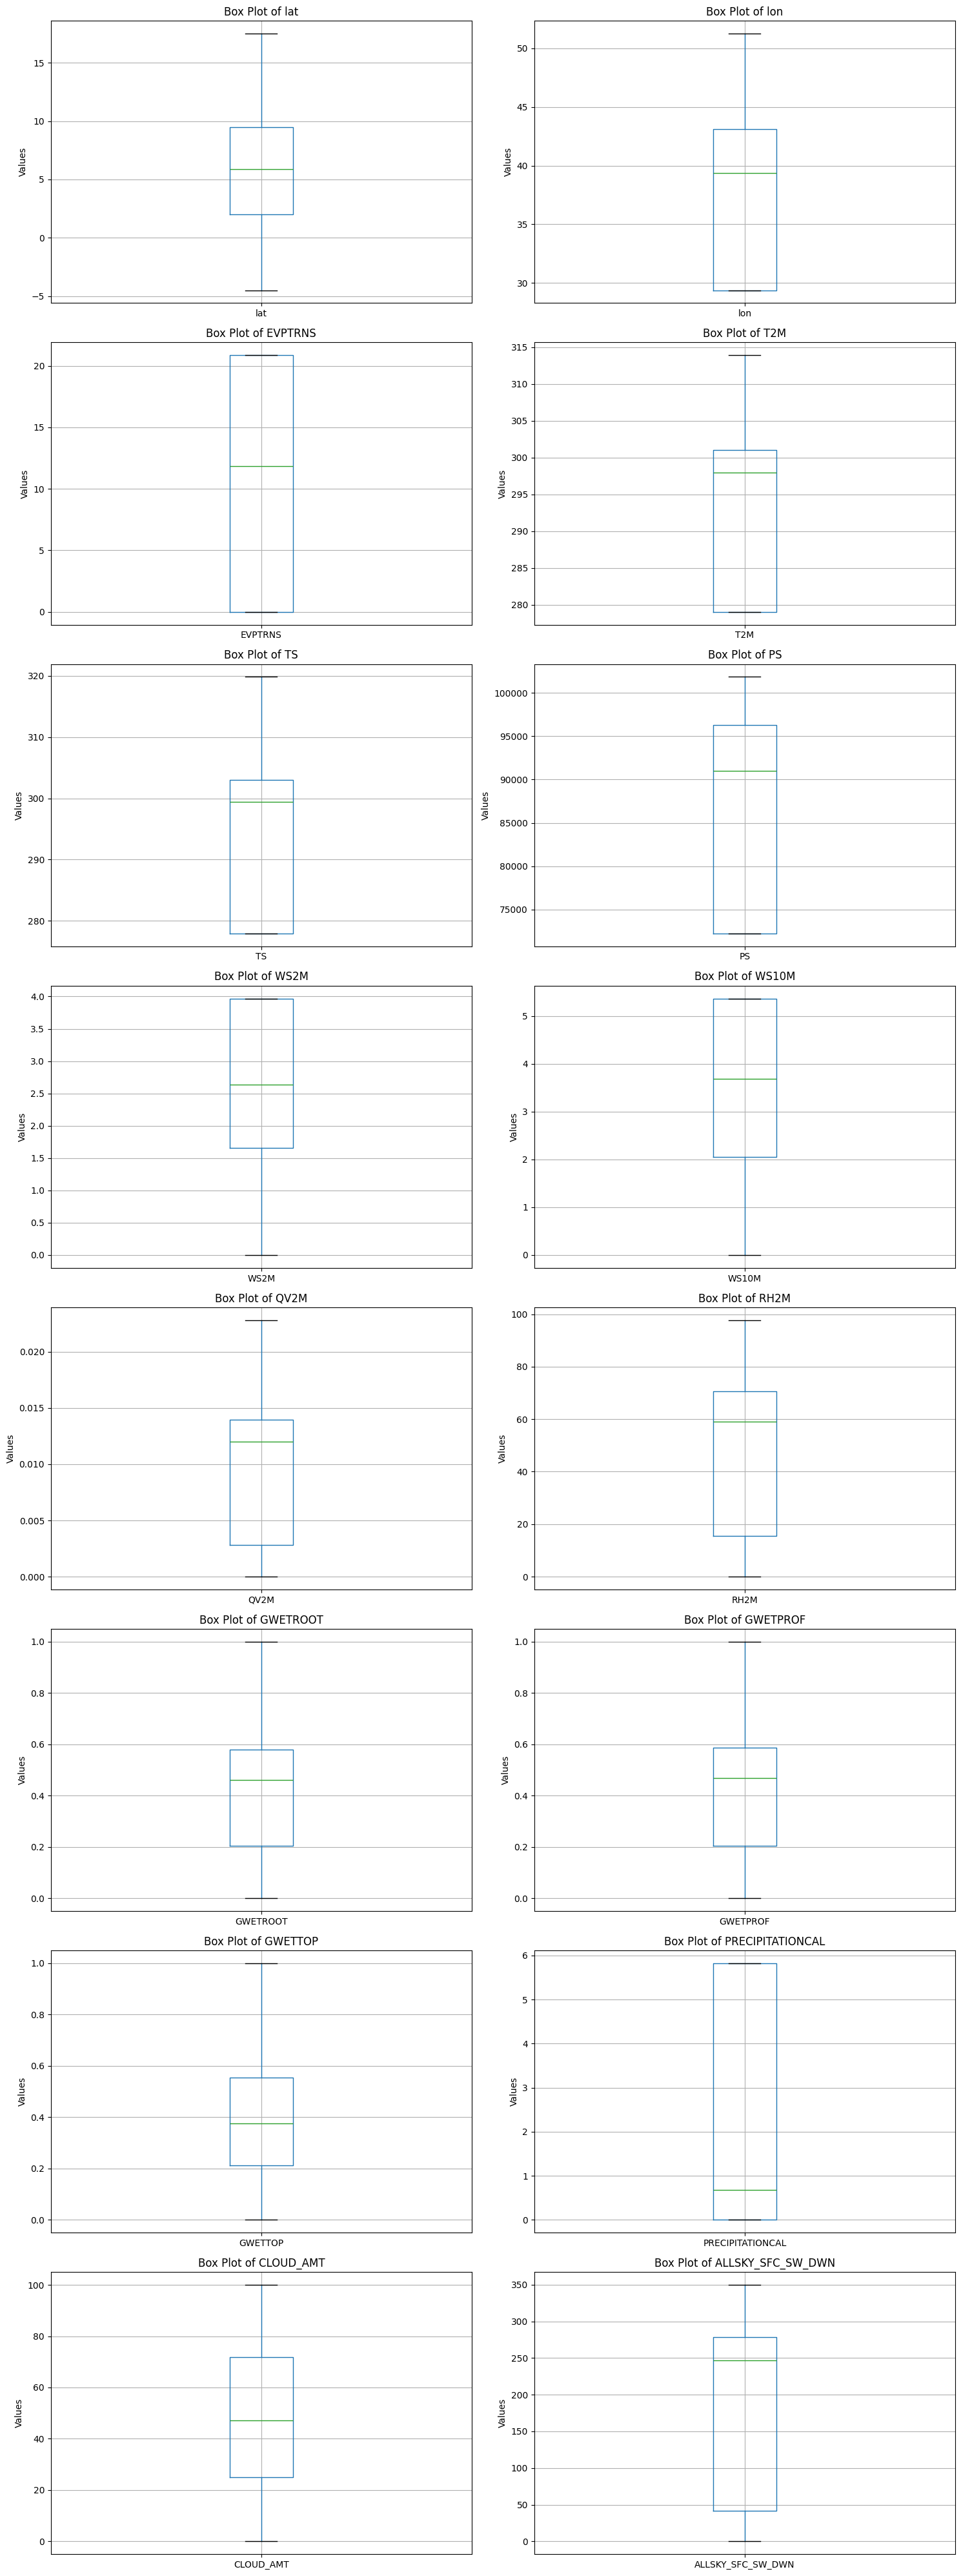

In [40]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

def plot_summary_stats(polars_df, show_summary_stats=False):
    """
    Generates box plots for numeric columns from a Polars DataFrame and optionally displays summary statistics.

    Parameters:
    - polars_df (pl.DataFrame): The input Polars DataFrame containing numeric data.
    - show_summary_stats (bool, optional): Flag to print summary statistics. Defaults to False.
    """
    if show_summary_stats:
        summary_stats = polars_df.describe()
        print("Summary Statistics:")
        print(summary_stats)

    # Converting to Pandas for matplotlib compatibility
    summary_stats_pandas = polars_df.to_pandas()

    # Filtering out non-numeric columns
    numeric_df = summary_stats_pandas.select_dtypes(include=[np.number])

    # Number of rows and columns for the subplot grid
    nrows = int(np.ceil(len(numeric_df.columns) / 2))
    ncols = 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))

    # Flatten axes array if more than one row
    if nrows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Iterate over each column and create a boxplot
    for ax, column in zip(axes, numeric_df.columns):
        numeric_df.boxplot(column=column, ax=ax, showfliers=False)
        ax.set_title(f'Box Plot of {column}')
        ax.set_ylabel('Values')

    # Hide any empty subplot areas
    for ax in axes[len(numeric_df.columns):]:
        ax.remove()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_summary_stats(summary_stats_polars)


#### Why some have lines within the box plots and some don't?

The absence of a line also known as "whiskers" between the upper quartile and the maximum value (or the lower quartile and the minimum value) suggests that the maximum (or minimum) value lies within the upper (or lower) quartile; in other words, the maximum value is not beyond the range that would typically define an outlier. 

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def plot_variable_distributions(dataset, sample_times=10):
    """
    Plots histograms of variables in an xarray.Dataset for randomly sampled timestamps.
    
    Parameters:
    - dataset (xarray.Dataset): The dataset containing the variables.
    - sample_times (int): The number of timestamps to randomly sample for plotting histograms.
    
    This function plots histograms for data variables that include the 'timestamp' dimension,
    after randomly selecting a number of timestamps.
    """
    
    # Filter out the excluded variables
    variables = [var for var in dataset.data_vars]
    
    # Prepare the figure layout
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))  # Only one column of plots now
    
    # Handle case when there is only one variable to plot
    if n_vars == 1:
        axes = [axes]
    
    for i, var in enumerate(variables):
        data_var = dataset[var]
        
        # Check if the 'timestamp' dimension exists for the variable
        if 'timestamp' in data_var.dims:
            random_indices = np.random.choice(dataset.timestamp.size, size=sample_times, replace=False)
            sampled_times = data_var.isel(timestamp=random_indices)
            for time in sampled_times:
                axes[i].hist(time.values.flatten(), bins=30, alpha=0.5)
            # Removed the legend line
            axes[i].set_title(f'Histograms of {var}')
        else:
            axes[i].text(0.5, 0.5, 'No timestamp dimension', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Histograms of {var} (not available)')
    
    plt.tight_layout()
    plt.show()


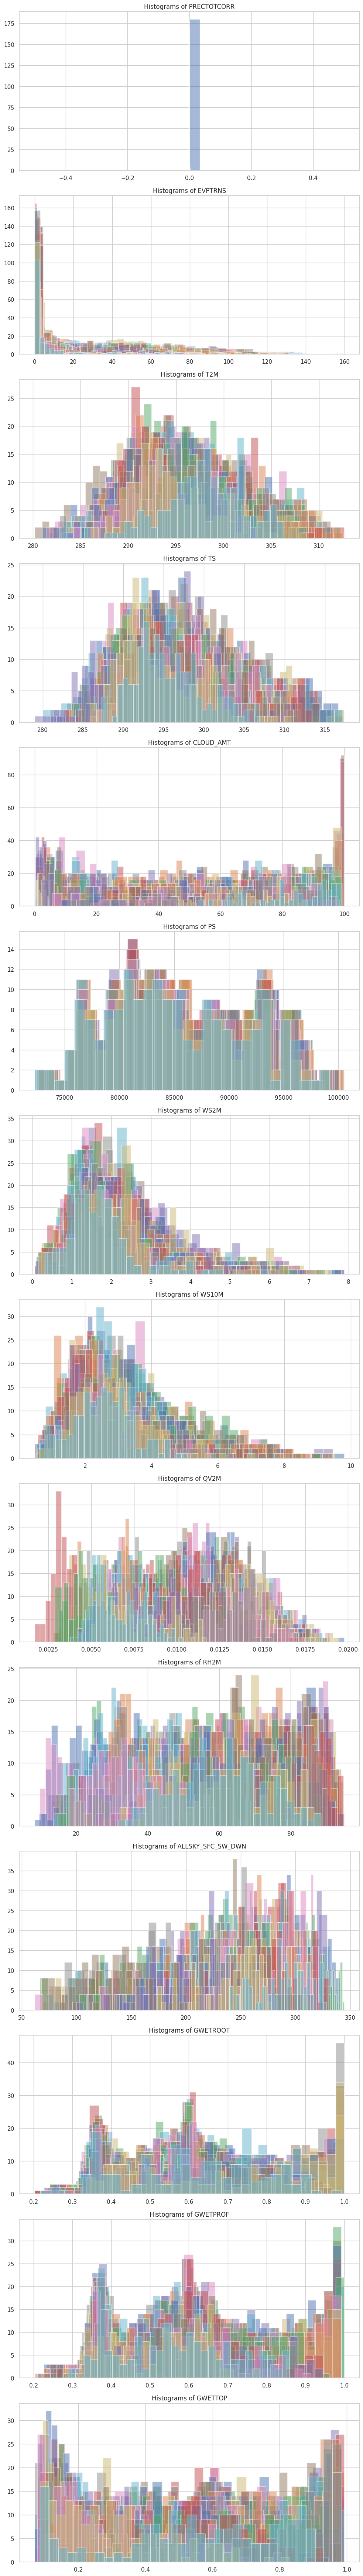

In [15]:
# Usage example:
# Assuming 'ds' is your xarray.Dataset loaded with data
plot_variable_distributions(ds, sample_times=180)

In [16]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def plot_variable_distributions(dataset, sample_times=100):
    """
    Plots histograms of variables in an xarray.Dataset for randomly sampled timestamps.

    This function is designed to visualize the distribution of each data variable that includes the
    'timestamp' dimension in the dataset. It allows the user to specify how many random timestamps
    to sample for the histograms, enabling a quick visualization of data variability over time.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing the variables to plot.
    - sample_times (int): The number of random timestamps to sample from the dataset.

    The histograms help in understanding the distribution and potential anomalies or patterns in the dataset,
    which can be critical for further data analysis or modeling steps.
    """
    
    # Filter out the excluded variables and prepare plots
    variables = [var for var in dataset.data_vars]
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))  # Adjusted layout for clarity
    
    # Handle single variable case
    if n_vars == 1:
        axes = [axes]
    
    # Iterate through variables to plot histograms
    for i, var in enumerate(variables):
        data_var = dataset[var]
        # Only plot if 'timestamp' is a dimension
        if 'timestamp' in data_var.dims:
            random_indices = np.random.choice(dataset.timestamp.size, size=sample_times, replace=False)
            sampled_data = data_var.isel(timestamp=random_indices)
            axes[i].hist(sampled_data.values.flatten(), bins=30, alpha=0.5, label=f'Timestamps sampled')
            axes[i].set_title(f'Histogram of {var}')
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, 'No timestamp dimension', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Variable {var} does not have a timestamp dimension')
    
    plt.tight_layout()
    plt.show()


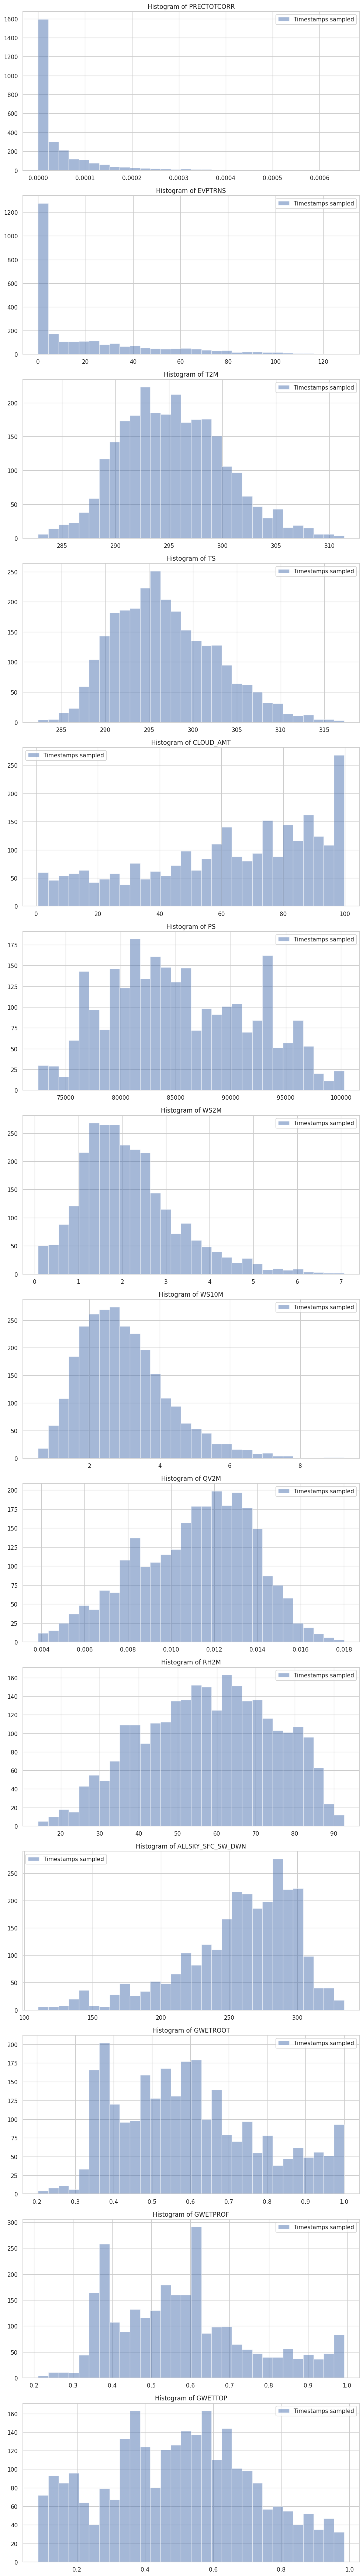

In [17]:
# Example Usage:
# dataset = xr.open_dataset('path_to_your_netcdf_file.nc')
plot_variable_distributions(ds, sample_times=15)